In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from skimage import io
from skimage.draw import disk

from titiler.openeo.processes.implementations.lego import find_best_lego_color

os.environ["TITILER_OPENEO_LEGO_COLORS_FILE"] = "/home/emathot/Workspace/DevelopmentSeed/titiler-openeo/deployment/k8s/charts/files/lego_colors_water.json"



Loaded coastline shapefile with 65751 features


In [2]:
def compress(img, NPIXEL=32):
    min_side = min(img.shape[:2])
    new_shape = np.round(np.array(img.shape[:2]) / min_side * NPIXEL)
    new_shape = tuple(new_shape.astype(int))[::-1]
    small_img = cv.resize(img, new_shape, interpolation=cv.INTER_AREA)
    return small_img

In [3]:
def upscale(img, PIXELSIZE=16):
    new_shape = PIXELSIZE * np.array(img.shape[:2])
    new_shape = tuple(new_shape.astype(int))[::-1]
    res = cv.resize(img, new_shape, interpolation=cv.INTER_NEAREST)
    return res

In [4]:
def legofication(img, nblocks):
    nmin = np.min(nblocks)
    d = (np.min(np.array(img.shape[:2])) // nmin) / 2

    for i in range(nblocks[0]):
        for j in range(nblocks[1]):
            xc = round(d + 2 * d * i)
            yc = round(d + 2 * d * j)
            cur_color = np.copy(img[xc, yc, :])

            rr, cc = disk((xc - 2, yc - 2), 0.6 * d, shape=img.shape)
            img[rr, cc] = (img[rr, cc] * 0.5 + np.array([200, 200, 200]) * 0.5).astype(np.uint8)

            rr, cc = disk((xc + 2, yc + 2), 0.6 * d, shape=img.shape)
            img[rr, cc] = (img[rr, cc] * 0.5 + np.array([30, 30, 30]) * 0.5).astype(np.uint8)

            rr,cc = disk((xc, yc), 0.6 * d, shape=img.shape)
            img[rr, cc] = cur_color

    return img

In [ ]:
# img = io.imread('/home/emathot/Downloads/Cloud-free_Europe_pillars.jpg')
img = io.imread('/home/emathot/Downloads/esa_screen_white.jpg')
small_img = compress(img, NPIXEL=24)
print(small_img.shape)
# Map each pixel to the closest LEGO color
cache = {}
for i in range(small_img.shape[0]):
    for j in range(small_img.shape[1]):
        if (small_img[i, j][0], small_img[i, j][1], small_img[i, j][2]) in cache:
            small_img[i, j] = cache[(small_img[i, j][0], small_img[i, j][1], small_img[i, j][2])]
        else:
            small_img[i, j] = find_best_lego_color(small_img[i, j])[1]
            cache[(small_img[i, j][0], small_img[i, j][1], small_img[i, j][2])] = small_img[i, j]
lego_img = upscale(small_img, PIXELSIZE=16)
lego_img = legofication(lego_img, small_img.shape[:2])
print(lego_img.shape)

(24, 24, 3)
(384, 384, 3)


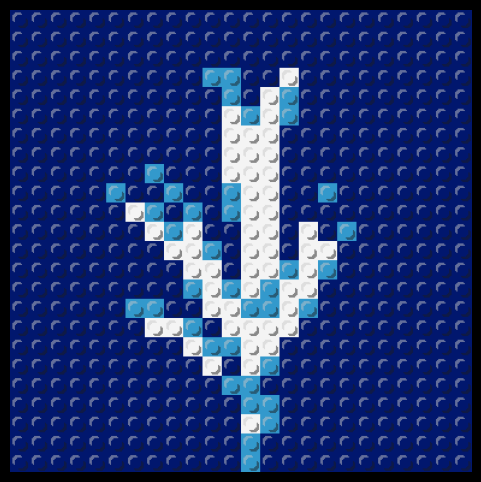

In [8]:
fig = plt.figure(figsize=(6, 6))
plt.imshow(lego_img)
plt.gca().axis('off')
plt.gcf().set_facecolor('black')

In [13]:
io.imsave('lego.jpg', lego_img, quality=100)
io.imsave('lego_mosaic.jpg', small_img, quality=100)

/tmp/ipykernel_1821892/2786376516.py:1: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  io.imsave('lego.jpg', lego_img, quality=100)
/tmp/ipykernel_1821892/2786376516.py:2: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imsave`.
  io.imsave('lego_mosaic.jpg', small_img, quality=100)
